Q1) How can farming practices be optimised while promoting sustainability and reducing environmental impact?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

In [2]:
farmer_df = pd.read_csv('./data/farmer_advisor_dataset.csv')
farmer_df.drop(columns='Farm_ID', inplace=True)

In [3]:
encoder = OneHotEncoder(sparse_output=False)

def create_random_forest_reg(col_to_pred, crop_type = None, drop_crop_yield = True, max_depth = 5):
    temp_df = farmer_df.copy(deep=True)
    true_y = temp_df[col_to_pred]
    temp_df.drop(columns=col_to_pred, inplace=True)

    if drop_crop_yield:
        temp_df.drop(columns='Crop_Yield_ton', inplace=True)
    
    if crop_type is None:
        one_hot_encoded = encoder.fit_transform(temp_df[['Crop_Type']])

        one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Crop_Type']))
    else:
        one_hot_df = temp_df[temp_df['Crop_Type'] == crop_type].reset_index(drop=True).drop(columns=['Crop_Type'])

    df_encoded = pd.concat([temp_df, one_hot_df], axis=1)

    x = df_encoded.drop(['Crop_Type'], axis=1)

    reg = RandomForestRegressor(max_depth = max_depth).fit(x, true_y)

    del temp_df
    return reg, x, true_y

In [4]:
def score_reg(reg, x, true_y):
    predictions = reg.predict(x)

    mse = mean_squared_error(true_y, predictions)
    print(f'Mean Squared Error: {mse}')

    r2 = r2_score(true_y, predictions)
    print(f'R-squared: {r2}')

In [5]:
def analyse_model(reg, x, outcome_var, max_depth=3, plot_graph = True):
    tree_to_plot = reg.estimators_[0]

    # Plot the decision tree
    plt.figure(figsize=(16, 6))
    plot_tree(tree_to_plot, feature_names=x.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=max_depth)
    plt.title(F"Decision Tree from Random Forest to predict {outcome_var}")
    plt.show()

    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': reg.feature_importances_,
                                            'feature': x.columns}).set_index('feature').sort_values('feature_importance', ascending = False)

    print(feature_importance_df)

    if plot_graph:
        plt.figure(figsize=(16, 6))
        sns.barplot(feature_importance_df, x = 'feature', y= 'feature_importance')
        plt.show()


In [6]:
sustainability_reg_40, sustainability_x_40, sustainability_y_40 = create_random_forest_reg('Sustainability_Score',drop_crop_yield=True, max_depth=40)

In [8]:
score_reg(sustainability_reg_40, sustainability_x_40, sustainability_y_40)

Mean Squared Error: 128.14950156376116
R-squared: 0.8440478275785791


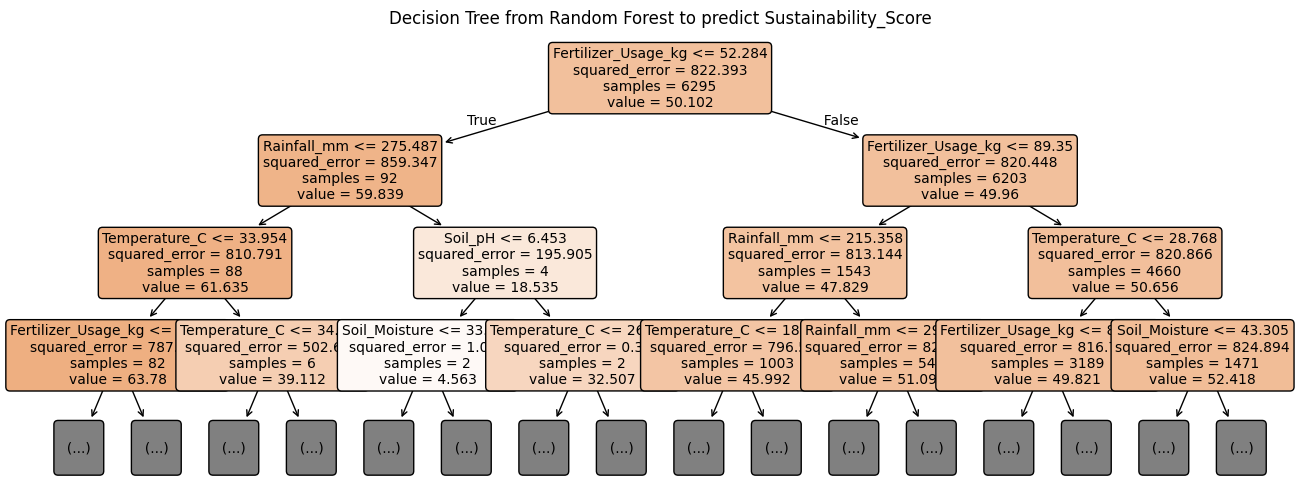

                     feature_importance
feature                                
Fertilizer_Usage_kg            0.159310
Pesticide_Usage_kg             0.157995
Rainfall_mm                    0.157707
Temperature_C                  0.156858
Soil_pH                        0.156286
Soil_Moisture                  0.155841
Crop_Type_Corn                 0.014546
Crop_Type_Rice                 0.014531
Crop_Type_Wheat                0.013526
Crop_Type_Soybean              0.013400


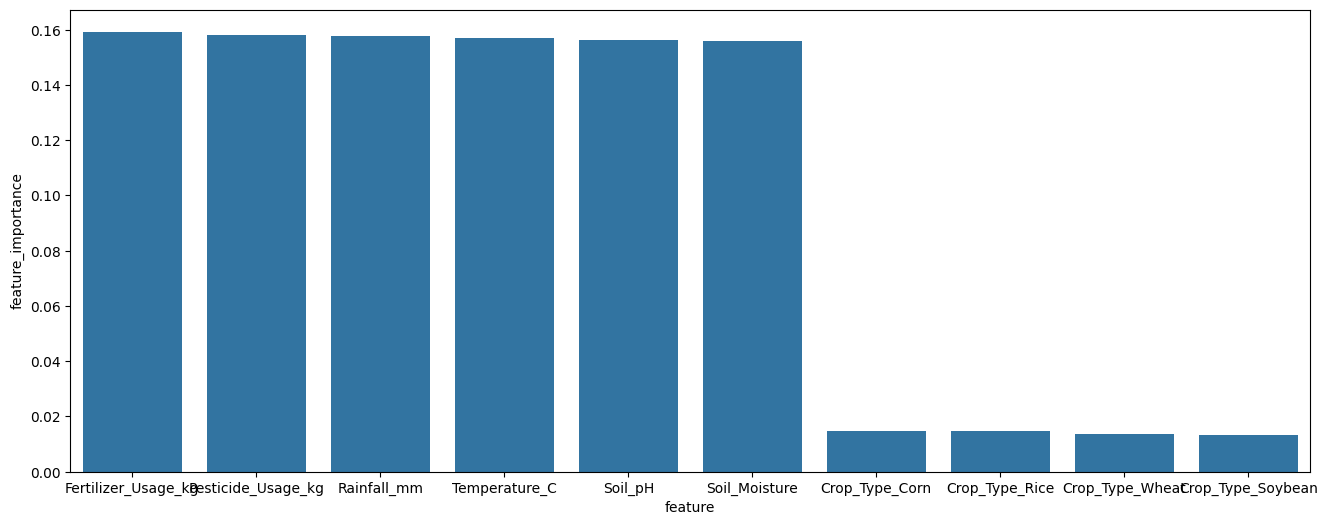

In [ ]:
analyse_model(sustainability_reg_40, sustainability_x_40, outcome_var='Sustainability_Score')

Analyzing by Crop Type

In [ ]:
for crop_type in farmer_df['Crop_Type'].unique():
    print(F"Details for {crop_type}")
    model, x, y = create_random_forest_reg('Sustainability_Score',crop_type=crop_type, drop_crop_yield=True, max_depth=40)
    score_reg(model, x, y)
    analyse_model(model, x,outcome_var=F'Sustainability_Score of {crop_type}', plot_graph = False, max_depth=2)

This tells us Fertizlizer usage, pesticide usage and rainfall_mm have the most entropy on the Sustainability_Score

Analysing Crop Yield

In [ ]:
crop_yield_reg, crop_yield_x, crop_yield_y = create_random_forest_reg('Crop_Yield_ton',drop_crop_yield=False, max_depth=None)

In [ ]:
score_reg(crop_yield_reg, crop_yield_x, crop_yield_y)

In [ ]:
analyse_model(crop_yield_reg, crop_yield_x, outcome_var='Crop_Yield_ton')

In [ ]:
for crop_type in farmer_df['Crop_Type'].unique():
    print(F"Details for {crop_type}")
    model, x, y = create_random_forest_reg('Crop_Yield_ton',crop_type=crop_type, drop_crop_yield=False, max_depth=40)
    score_reg(model, x, y)
    analyse_model(model, x,outcome_var=F'Crop_Yield_ton of {crop_type}', plot_graph = False, max_depth=2)